In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LR 
import graphviz  
import pydotplus  
from sklearn.tree import export_graphviz
from IPython.display import Image
from scipy import stats
from sklearn.tree import DecisionTreeRegressor

In [2]:
DF = pd.read_csv("dataset_world_happiness.csv")
DFsub = pd.read_csv('submission_world_happiness.csv')
DFsub=DFsub.rename(columns = {'Unnamed: 0':'ID'})
DFsub

,ID,Country,Region,Happiness Rank,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,0,NaN,Norway,2,1.456000,NaN,0.861000,0.686000,0.340000,0.286000,NaN,2018
1,1,Myanmar,Southeastern Asia,119,0.341120,0.699810,0.398800,0.426920,0.202430,0.819710,1.506550,2016
2,2,Nigeria,Sub-Saharan Africa,103,0.752160,0.644980,0.051080,0.278540,0.030500,0.232190,2.885860,2016
3,3,NaN,Cyprus,61,1.229000,NaN,0.909000,0.423000,0.035000,0.202000,NaN,2018
4,4,Romania,Central and Eastern Europe,71,1.169700,0.728030,0.676020,0.367120,0.006790,0.128890,2.451840,2016
5,5,NaN,Mongolia,94,0.914000,NaN,0.575000,0.395000,0.032000,0.253000,NaN,2018
6,6,Central African Republic,Sub-Saharan Africa,148,0.078500,0.000000,0.066990,0.488790,0.082890,0.238350,2.722300,2015
7,7,NaN,Benin,136,0.378000,NaN,0.240000,0.440000,0.067000,0.163000,NaN,2018
8,8,New Zealand,NaN,8,1.405706,1.548195,0.816760,0.614062,0.382817,0.500005,2.046456,2017
9,9,NaN,Niger,134,0.131000,NaN,0.221000,0.390000,0.099000,0.175000,NaN,2018


## Cleaning dataset_world_happiness - before merge

In [3]:

#*********** Cleaning Country Column ***********#
mask = DF.Country.isnull()                       # Gets index of where "Country" is null == mask
DF.loc[mask, 'Country'] = DF.loc[mask,'Region']  # Inserts the value in "Region" at the same index into "Country"   

idx = DF.Country == DF.Region   # Finds index of where "Region" == "Country"
DF.loc[idx,'Region'] = np.nan   # Replaces "Region" with NaN


#************ Cleaning Region Column *************#
for i in range(len(DF['Region'])):
    
    if pd.isnull(DF.loc[i,'Region']):   # Locating cell of Null values for Region 
        country = DF.loc[i,'Country']   # stores Country of postion i 
        
        for x in range(len(DF['Country'])):
            # going through DF['Country'] until we find 'country' value and if Region is not null 
            if DF.loc[x,'Country'] == country and pd.notnull(DF.loc[x,'Region']):
                DF.loc[i,'Region'] = DF.loc[x,'Region']  # Storing Region value from postion x into position i
                break     # Breaking out of loop 

#  Some countries were not previously defined with their 'Region'
#  looked at what countries need a region defined to it
indexNullRegion = DF[DF['Region'].isnull()].index.to_numpy()
NullRegion_values = ['Southeastern Asia','Eastern Asia','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Central and Eastern Europe','Middle East and Northern Africa',
                    'Sub-Saharan Africa']
counter=0;
for i in indexNullRegion:            # Storing remaining regions 
    if counter< 11:
        DF.loc[i,'Region'] = NullRegion_values[counter]
        counter+=1
        
#************ Cleaning Family Column ************# 

# mean for close values ; median for outliers 

# Based on 'Region', getting means for 'Family'
RegionGrouped = DF.groupby('Region')['Family'].mean() 
indexNullFamily = DF[DF['Family'].isnull()].index.to_numpy()

for i in indexNullFamily:
    DF.loc[i,'Family'] = RegionGrouped[DF.loc[i,'Region']]
    
#*********** Cleaning Dystopia Residual ********#

# Getting mean for the entire Column for 'Dystopia Residual'
indexNullDR = DF[DF['Dystopia Residual'].isnull()].index.to_numpy()
DRmean = DF['Dystopia Residual'].mean() 
DF.loc[indexNullDR,'Dystopia Residual'] = DRmean 

#***********Trust (Government Corruption)*******#

# Getting mean for the entire Column for 'Trust (Government Corruption)'
Trustmean = DF["Trust (Government Corruption)"].mean()
indexNullTrust = DF[DF['Trust (Government Corruption)'].isnull()].index.to_numpy()
DF.loc[indexNullTrust,'Trust (Government Corruption)'] = Trustmean 



## Droping outliers before Merging with Submission

In [4]:

#***************Droping Outliers********************#

#   GDP Per Capita outliers 
z= np.abs(stats.zscore(DF['GDP Per Capita']))
DF = DF[(z < 3)]

#   Family outliers 
z= np.abs(stats.zscore(DF['Family']))
DF = DF[(z < 3)]

#  Health (Life Expectancy) Outliers 
z= np.abs(stats.zscore(DF['Health (Life Expectancy)']))
DF = DF[(z < 3)]

#  Freedom Outliers 
z= np.abs(stats.zscore(DF['Freedom']))
DF = DF[(z < 3)]

#  Trust (Government Corruption) outliers 
z= np.abs(stats.zscore(DF['Trust (Government Corruption)']))
DF = DF[(z < 3)]

#   Generosity outliers 
z= np.abs(stats.zscore(DF['Generosity']))
DF = DF[(z < 3)]

#   Dystopia Residual outliers 
z= np.abs(stats.zscore(DF['Dystopia Residual']))
DF = DF[(z < 3)]

indexValueIndex = DF.shape
indexValueIndex

(720, 12)

## Merging World Happiness data + Submission data

In [5]:
DF = DF.append(DFsub, ignore_index=True)
# DF=bigdata.drop(columns=['Unnamed: 0'])


## Cleaninging entire DataSet 

In [6]:

#*********** Cleaning Country Column ***********#
mask = DF.Country.isnull()                       # Gets index of where "Country" is null == mask
DF.loc[mask, 'Country'] = DF.loc[mask,'Region']  # Inserts the value in "Region" at the same index into "Country"   

idx = DF.Country == DF.Region   # Finds index of where "Region" == "Country"
DF.loc[idx,'Region'] = np.nan   # Replaces "Region" with NaN


#************ Cleaning Region Column *************#
for i in range(len(DF['Region'])):
    
    if pd.isnull(DF.loc[i,'Region']):   # Locating cell of Null values for Region 
        country = DF.loc[i,'Country']   # stores Country of postion i 
        
        for x in range(len(DF['Country'])):
            # going through DF['Country'] until we find 'country' value and if Region is not null 
            if DF.loc[x,'Country'] == country and pd.notnull(DF.loc[x,'Region']):
                DF.loc[i,'Region'] = DF.loc[x,'Region']  # Storing Region value from postion x into position i
                break     # Breaking out of loop 

#  Some countries were not previously defined with their 'Region'
#  looked at what countries need a region defined to it
indexNullRegion = DF[DF['Region'].isnull()].index.to_numpy()
NullRegion_values = ['Southeastern Asia','Eastern Asia','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Central and Eastern Europe','Middle East and Northern Africa',
                    'Sub-Saharan Africa']
counter=0;
for i in indexNullRegion:            # Storing remaining regions 
    if counter< 11:
        DF.loc[i,'Region'] = NullRegion_values[counter]
        counter+=1
        
#************ Cleaning Family Column ************# 

# mean for close values ; median for outliers 

# Based on 'Region', getting means for 'Family'
RegionGrouped = DF.groupby('Region')['Family'].mean() 
indexNullFamily = DF[DF['Family'].isnull()].index.to_numpy()

for i in indexNullFamily:
    DF.loc[i,'Family'] = RegionGrouped[DF.loc[i,'Region']]
    
#*********** Cleaning Dystopia Residual ********#

# Getting mean for the entire Column for 'Dystopia Residual'
indexNullDR = DF[DF['Dystopia Residual'].isnull()].index.to_numpy()
DRmean = DF['Dystopia Residual'].mean() 
DF.loc[indexNullDR,'Dystopia Residual'] = DRmean 

#***********Trust (Government Corruption)*******#

# Getting mean for the entire Column for 'Trust (Government Corruption)'
Trustmean = DF["Trust (Government Corruption)"].mean()
indexNullTrust = DF[DF['Trust (Government Corruption)'].isnull()].index.to_numpy()
DF.loc[indexNullTrust,'Trust (Government Corruption)'] = Trustmean 


In [7]:
indexSub = 720

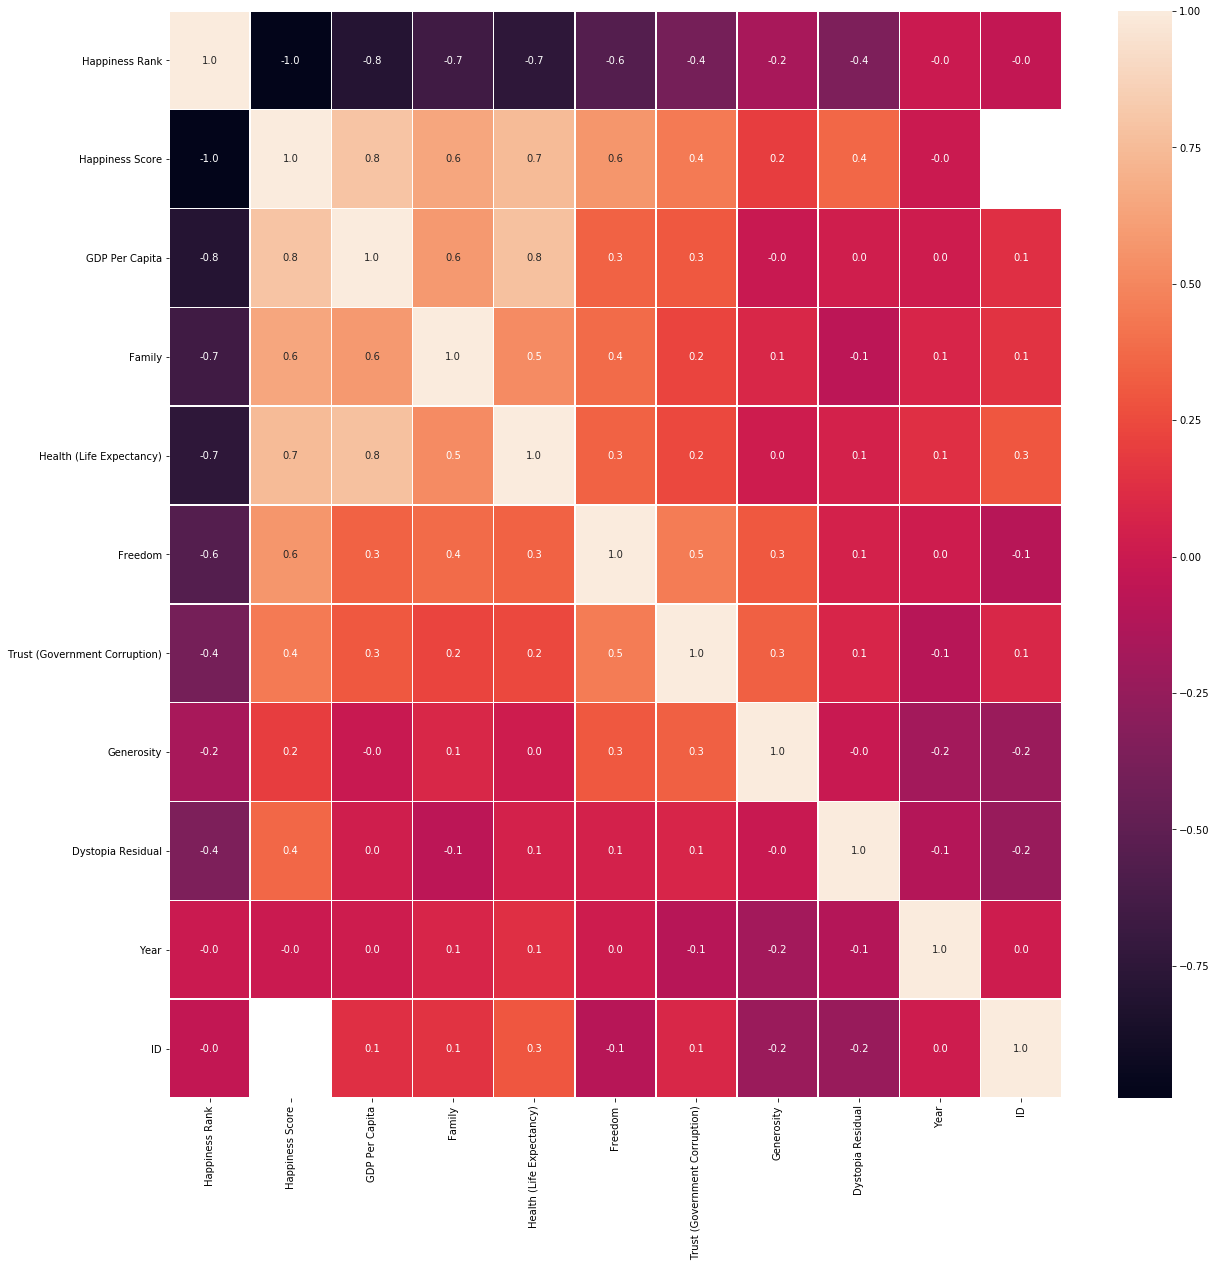

In [8]:
# LOOKING AT CORRELATIONS 
corr=DF.corr()
corr
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(corr,annot=True,linewidths=.5,fmt='.1f',ax=ax)
plt.show()

# Year | Dystopia Residual | Generosity == Little correlations 
# Country == Region Meaning similar ---- may not have any correlation - Refer to piechart/histogram

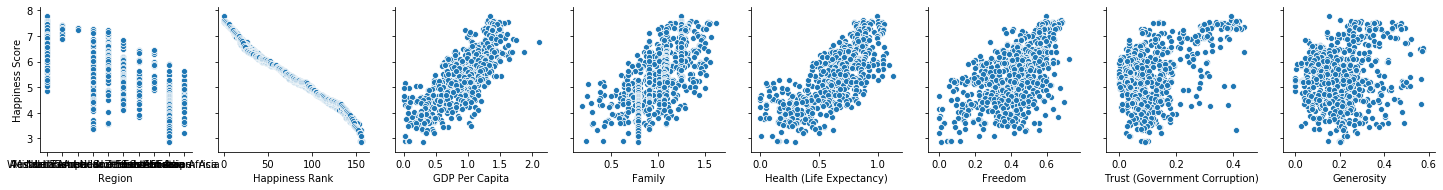

In [9]:

sns.pairplot(DF,x_vars=['Region', 'Happiness Rank',
       'GDP Per Capita', 'Family','Health (Life Expectancy)','Freedom',
       'Trust (Government Corruption)','Generosity'],y_vars='Happiness Score');

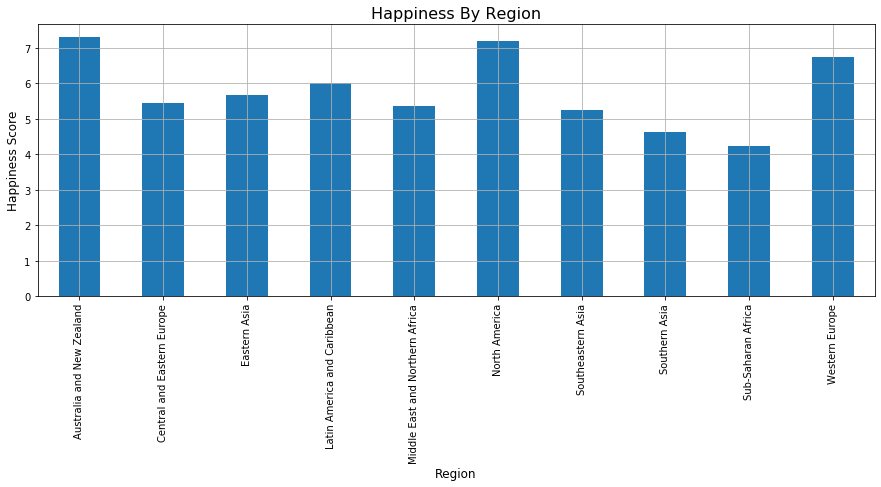

In [10]:
RegionGrouped = DF.groupby('Region')['Happiness Score'].mean()
RegionGrouped.plot.bar()
plt.title("Happiness By Region", fontsize = 16)
plt.ylabel("Happiness Score", fontsize = 12)
plt.xlabel("Region",fontsize = 12)
plt.gcf().set_size_inches(15,5)
plt.grid();

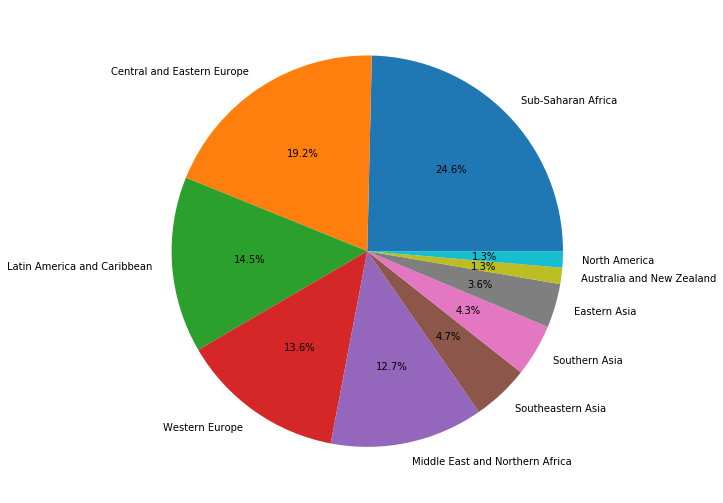

In [11]:
labels = DF.Region.value_counts().index
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sizes = DF.Region.value_counts().values
plt.pie(sizes, explode = explode, labels = labels, autopct = '%1.1f%%')
plt.gcf().set_size_inches(9,9);

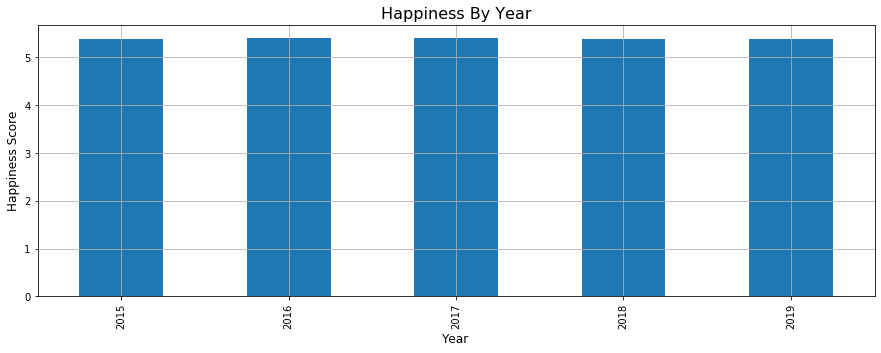

In [12]:
YearGrouped = DF.groupby('Year')['Happiness Score'].mean()
YearGrouped.plot.bar()
plt.title("Happiness By Year", fontsize = 16)
plt.ylabel("Happiness Score", fontsize = 12)
plt.xlabel("Year",fontsize = 12)
plt.gcf().set_size_inches(15,5)
plt.grid();

In [13]:
# Gathering our X and Y data for train/test

X = pd.get_dummies(DF[0:indexSub][[ 'Happiness Rank',
       'GDP Per Capita', 'Family','Health (Life Expectancy)','Freedom',
       'Trust (Government Corruption)' ,'Generosity']]).to_numpy()

Y = np.array(DF[0:indexSub]['Happiness Score'])


In [14]:
def train_test(X,Y,method):
    mse=[]
    for i in range(200):
        xtrain,xtest,ytrain,ytest=train_test_split(X,Y)
        method.fit(xtrain,ytrain)
        YP=method.predict(xtest)
        mse.append(mean_squared_error(ytest,YP))
    return mse

0.009404218229647616


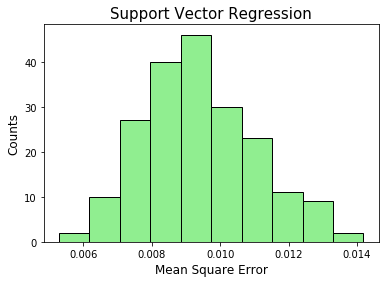

In [15]:
mse = train_test(X,Y,SVR())
plt.hist(mse,edgecolor="black",color="lightgreen");
plt.title("Support Vector Regression",fontsize =15)
mse1 =np.array(mse).mean()
plt.xlabel("Mean Square Error",fontsize =12); plt.ylabel("Counts",fontsize=12);
print(mse1)

0.01608337570206577


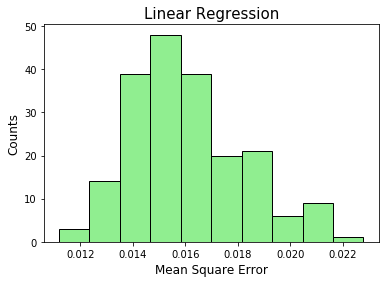

In [16]:
mse = train_test(X,Y,LR())
plt.hist(mse,edgecolor="black",color="lightgreen");
plt.title("Linear Regression",fontsize =15)
plt.xlabel("Mean Square Error",fontsize =12); plt.ylabel("Counts",fontsize=12);
mse2 =np.array(mse).mean()
print(mse2)

0.03464957612311689


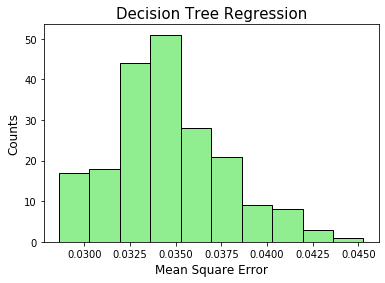

In [17]:

mse = train_test(X,Y,DecisionTreeRegressor(max_depth=3))
plt.hist(mse,edgecolor="black",color="lightgreen");
plt.title("Decision Tree Regression",fontsize =15)
plt.xlabel("Mean Square Error",fontsize =12); plt.ylabel("Counts",fontsize=12);
mse3 =np.array(mse).mean()
print(mse3)

In [18]:
# DF2019 = DF[DF['Year']==2019]
# DF2018 =  DF[DF['Year']==2018]
# DF2017 =  DF[DF['Year']==2017]
# DF2016 =  DF[DF['Year']==2016]
# DF2015 =  DF[DF['Year']==2015]

In [19]:
DF.describe()

,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,ID
count,743.000000,720.000000,743.000000,743.000000,743.000000,743.000000,743.000000,743.000000,743.000000,743.000000,23.00000
mean,78.041723,5.397312,0.918365,0.999372,0.614298,0.409424,0.119349,0.212517,2.107832,2017.036339,11.00000
std,44.381337,1.098405,0.399270,0.254698,0.245906,0.152553,0.096808,0.116081,0.377306,1.424667,6.78233
min,1.000000,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.899910,2015.000000,0.00000
25%,40.500000,4.534750,0.619500,0.791847,0.449596,0.309205,0.053140,0.127495,1.999450,2016.000000,5.50000
50%,78.000000,5.322000,0.982409,1.041670,0.650880,0.430000,0.089000,0.199000,2.092243,2017.000000,11.00000
75%,116.000000,6.168000,1.233374,1.176032,0.808579,0.527000,0.150600,0.270000,2.201575,2018.000000,16.50000
max,157.000000,7.769000,2.096000,1.610574,1.122000,0.724000,0.444000,0.819710,3.351680,2019.000000,22.00000


## Testing Method for Predictions

In [20]:
## import graphviz   # a standard graph visualization library
import pydotplus  # a graphing interface library for python
from sklearn.tree import export_graphviz
from IPython.display import Image # allows us to see the graphviz out in the notebook

## Decision Tree

In [21]:

data=pd.get_dummies(DF[:indexSub].drop(columns=["Happiness Score","ID"]))
Xmodel=np.array(data)
Ymodel=np.array(DF[:indexSub]["Happiness Score"]) 

features = list(data.columns)

classes= np.unique(Y)

xtrain,xtest,ytrain,ytest=train_test_split(Xmodel,Ymodel)
model=DecisionTreeRegressor(max_depth=5)
model.fit(xtrain,ytrain)

dot=export_graphviz(model,
                   rotate=True,
                    filled=True,
                   feature_names=features,
                   class_names=[str(u) for u in classes]) # creates a "dot" data structure

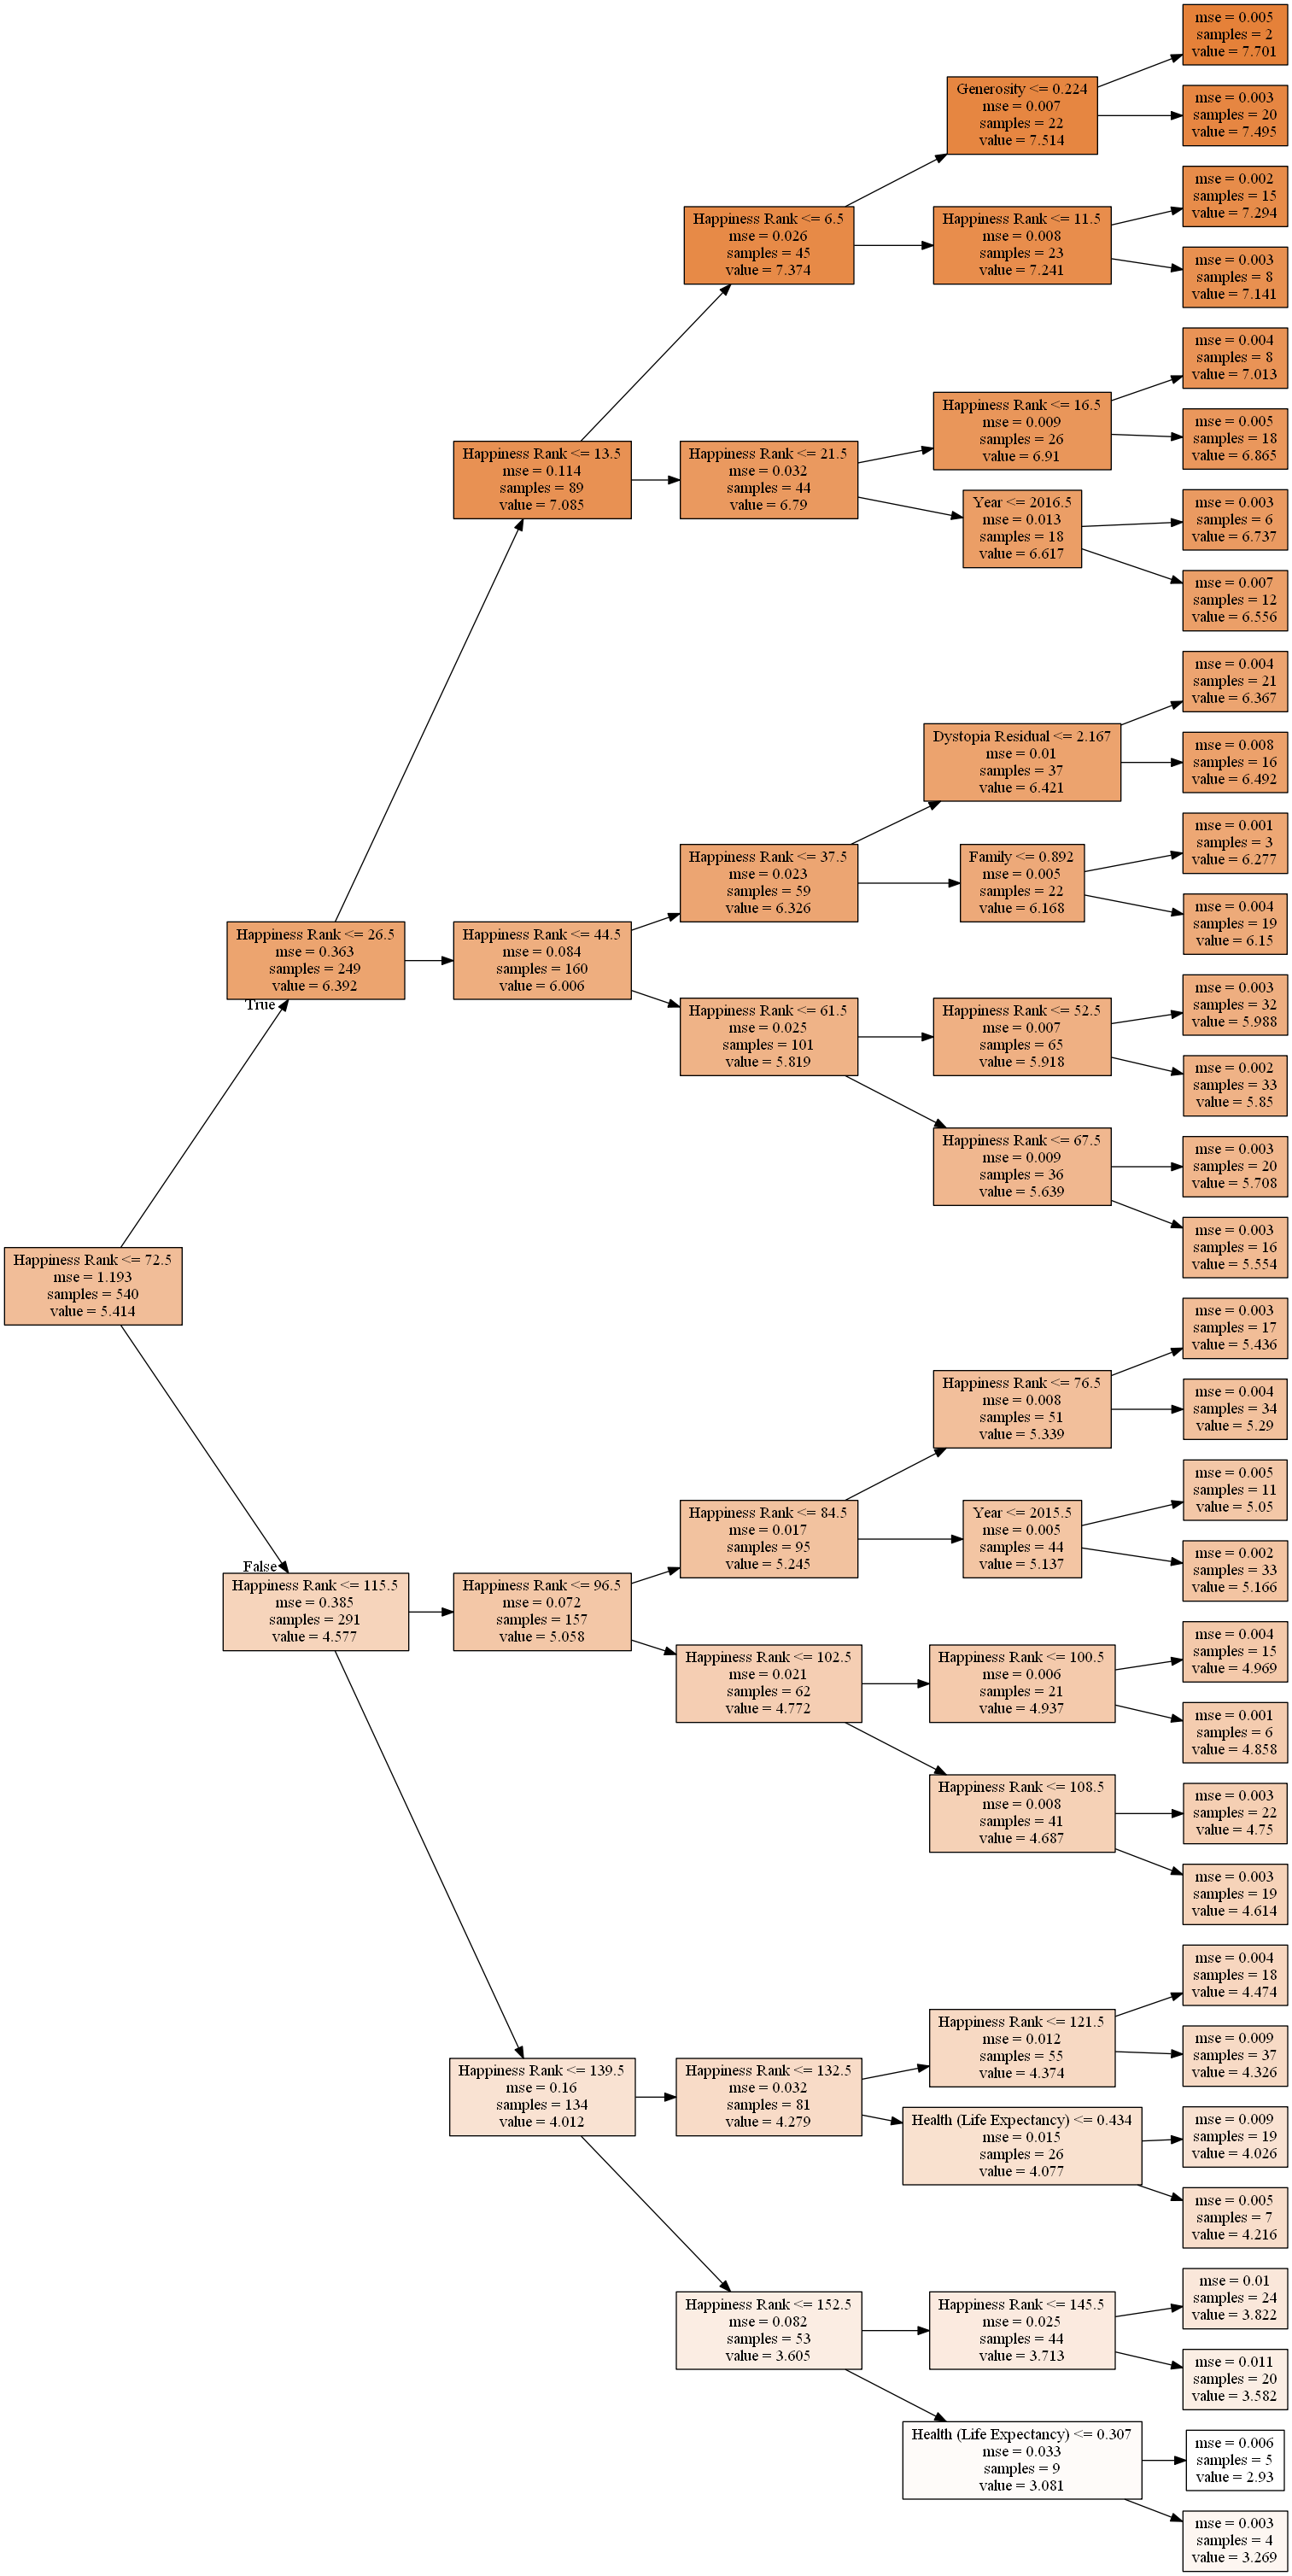

In [22]:
g=pydotplus.graph_from_dot_data(dot)
Image(g.create_png())

## Linear Regression

In [23]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y)
model = LR()
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)


In [24]:
df = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': ypred.flatten()})
df

,Actual,Predicted
0,4.180,4.170593
1,5.790,5.821305
2,3.808,3.844860
3,3.083,3.483537
4,4.707,4.641565
...,...,...
175,5.525,5.551624
176,6.652,6.788785
177,5.145,5.039376
178,4.433,4.409207


## Submission World Happiness 

In [25]:
#unnamedCol = DFsub['Unnamed: 0']
DFsub=DF[indexSub:]
Xsub =pd.get_dummies(DFsub[[ 'Happiness Rank',
       'GDP Per Capita', 'Family','Health (Life Expectancy)','Freedom',
       'Trust (Government Corruption)','Generosity' ]]).to_numpy()
Xsub.shape
yPredSub = model.predict(Xsub)
yPredSub

array([7.33975113, 4.55754312, 4.71287319, 5.80054611, 5.51644792,
       4.99356688, 3.70203119, 3.97152291, 7.23811758, 4.02456976,
       6.17289691, 6.54816448, 6.99889241, 5.73709222, 5.84112081,
       4.74908332, 5.89441493, 3.80920857, 3.69229837, 5.73706597,
       6.83750581, 6.37172803, 5.147493  ])

In [26]:
indexNullHS = DFsub[DFsub['Happiness Score'].isnull()].index.to_numpy()
counter=0;
for i in indexNullHS:            # Storing  predicted HS 
    if counter< len(yPredSub):
        DF.loc[i,'Happiness Score'] = yPredSub[counter]
        counter+=1

In [27]:
finalDF = pd.DataFrame(columns =['ID' ,'Happiness Score'])
finalDF['ID'] = DFsub['ID']
finalDF['Happiness Score'] = DFsub['Happiness Score']
finalDF

,ID,Happiness Score
720,0.0,7.339751
721,1.0,4.557543
722,2.0,4.712873
723,3.0,5.800546
724,4.0,5.516448
725,5.0,4.993567
726,6.0,3.702031
727,7.0,3.971523
728,8.0,7.238118
729,9.0,4.024570


In [28]:
finalDF.to_csv("finalDf.csv",index=False)